## Data Preparation
First we import our necessary libraries.

In [1]:
%%script echo skipping # Comment this line out if you want to install these packages
!pip install pygris
!pip install folium
!pip install rasterio
!pip install rasterstats

skipping # Comment this line out if you want to install these packages


In [2]:
# Load packages
%load_ext autoreload
%autoreload 2
import pygris
from pygris import tracts
from matplotlib import pyplot as plt
import pandas as pd
import folium
import numpy as np
import torch
from linear_regression import RidgeRegression
from rasterstats import zonal_stats
import rasterio
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

### Acquire Tract Geometries
As a test of concept, lets utilize the pygris library to access the CT tracts information and then let's do a simple plot to ensure it's correct.

Using FIPS code '09' for input 'CT'


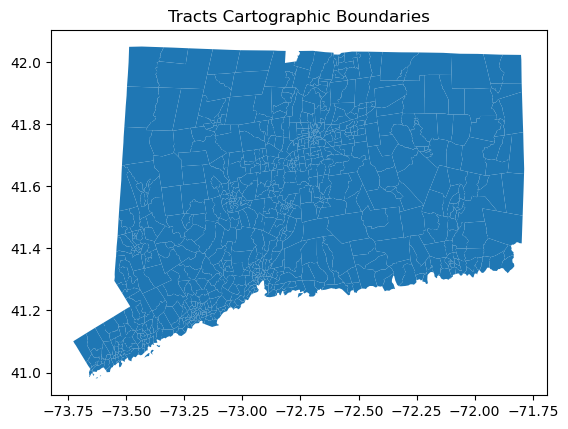

In [3]:
# Download geometry
ct_tracts = tracts(state = "CT", cb = True, cache = True, year = 2016)

# Display geometry
fig, ax = plt.subplots()
ct_tracts.plot(ax = ax)
plt.title("Tracts Cartographic Boundaries");

### Calculate Population Density

Before we begin our journey into zonal statistics and eventually creating a predictive model, we first want to understand what the population density looks like in Connecticut. We have some general hypotheses that the areas around New Haven and Hartford are going to have higher amounts of population, and we also expect to see some small pockets of communities around Connecticut.

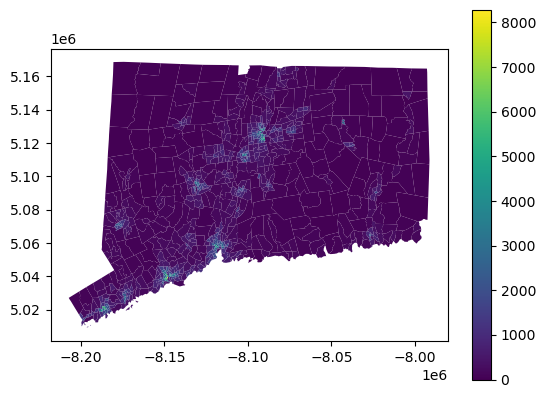

In [4]:
# Import tracts population data
pop = pd.read_csv("../data/population.csv")

# Convert data type so join key matches
ct_tracts["Geo_TRACT"] = ct_tracts["TRACTCE"].astype(int)

# Join attributes to geometry
tracts = ct_tracts.merge(pop, how = "inner", on='Geo_TRACT')

# Project tracts
tracts = tracts.to_crs("EPSG:3857")

# Calculate area in KM^2
tracts["Area"] = tracts.area/1000**2

# Calculate population density
tracts["PopDensity"] = tracts["SE_A00001_001"]/tracts["Area"]

# Create map
tracts.plot("PopDensity", legend = True);

## Intro to Zonal Statistics
We are going to do quite a bit here which is being abstracted away by the [`rasterio`](https://pypi.org/project/rasterio/) package. First and foremost, we are going to load in our landcover data from [CONUS](https://www.ncei.noaa.gov/products/satellite/gridded-goes-conus) which is created from satellite date of the Continental United States.

This data comes in the form of a `.tif` file which is a filetype used for storing geographic satellite data.

The goal of zonal statistics here is relatively straightforward, we are going to do some math that involves the pixels in a given geographic satellite image. Each pixel has an associated number which itself is associated with a key. Each pixel is contained in a "tract" which is a measurement of land by the US Census. We perform mathematics like finding the mean type of pixel in a given area, the max, the minimum, etc. This arithmetic is handled by the [`rasterstats`](https://pythonhosted.org/rasterstats/) package.

### First steps 
Here we open our path to our file, and more importantly, we set up our data to be used in zonal statistics. `.read` turns our data into a Numpy Array. Following this we are going to `.transform` our data, which means we are going to take the pixel locations of our coordinates (row col) and map them to our spatial coordinates (x, y). These coordinate values are relative to the [CRS](https://www.ncei.noaa.gov/products/satellite/gridded-goes-conus) (Coordinate Reference System) which we defined earlier as **"EPSG:2234"**

In [5]:
%%script echo skipping
#the data can be accessed from https://coastalimagery.blob.core.windows.net/ccap-landcover/CCAP_bulk_download/High_Resolution_Land_Cover/Phase_2_Expanded_Categories/Legacy_Land_Cover_pre_2024/CONUS/ct_2016_ccap_hires_landcover_20200915.zip
raster_path = '../data/ct_2016_ccap_hires_landcover_20200915.tif'
landcover = rasterio.open(raster_path)
arr = landcover.read(1)
affine = landcover.transform

skipping


### Performing Zonal statistics
It's as simple as importing rasterstats. We have handled the important data manipulation, and now it's basically plug and play! One function to note is `.to_crs` which takes in given coordinate reference system and transforms all the points in our dataframe to match that system.

The `rasterstats` library is very good at getting information from rasters, and we can in fact gain more information by using `categorical = True`. This allows to see the amount of each type of pixel at a given tract.

In [6]:
%%script echo skipping
df_new = zonal_stats(zone, arr, affine=affine, categorical = True)

skipping


Taking a look at our dataframe, we can confirm that each column is a type of pixel and each row is a tract

In [7]:
%%script echo skipping
df_categorical = pd.DataFrame(df_new)
df_categorical

skipping


## Visualizing Zonal Stats
Now that we have information on the amount of each pixel at a given tract, we can find the most common pixel per tract by using the function `.idxmax()` which will through each row and find the column with the largest value.

In [8]:
%%script echo skipping
df_categorical['max_type'] = df_categorical.idxmax(axis=1)
combined_df = pd.concat([tracts, df_categorical], axis=1)
combined_df['max_type'] = combined_df['max_type'].astype(str)

skipping


In [9]:
%%script echo skipping
combined_df.plot("max_type", legend = True);

skipping


### Saving this data
These statistics took quite a while to run, and it may be beneficial to save this data as a csv to continue running statistics in the future

In [10]:
%%script echo skipping

combined_df.to_csv('../data/combined_data.csv', index=False)

skipping


## Ordinary Linear Regression

### Data Preparation

First, we import our data.

In [11]:
# Import and display data
data = pd.read_csv("../data/combined_data.csv")
data.head()

,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,...,18,19,20,21,22,7,6,0,23,max_type
0,9,1,11000,1400000US09001011000,9001011000,110.0,CT,4473567,3841130,POLYGON ((-8191739.173321358 5013468.769836016...,...,136572.0,423692.0,142589.0,1378858.0,NaN,NaN,NaN,NaN,NaN,2
1,9,1,20800,1400000US09001020800,9001020800,208.0,CT,2315472,0,POLYGON ((-8187432.3302968815 5025136.84023609...,...,NaN,NaN,27939.0,NaN,NaN,NaN,NaN,NaN,NaN,11
2,9,1,21400,1400000US09001021400,9001021400,214.0,CT,1640443,0,POLYGON ((-8189589.702028457 5021116.993618919...,...,NaN,NaN,13728.0,NaN,NaN,NaN,NaN,NaN,NaN,2
3,9,1,22200,1400000US09001022200,9001022200,222.0,CT,1442382,117063,POLYGON ((-8186995.178656538 5019223.193891366...,...,NaN,20584.0,80161.0,99956.0,NaN,NaN,NaN,NaN,NaN,2
4,9,1,43100,1400000US09001043100,9001043100,431.0,CT,6652660,58522,POLYGON ((-8178763.436270848 5029936.759394648...,...,NaN,NaN,9940.0,68655.0,486.0,NaN,NaN,NaN,NaN,11


Looks like there is some missing data in tracts that contain no pixels of a certain class.
Let's impute 0 for all `NaN` values.

In [12]:
# Impute 0 for missing data
print("Before imputation, there were", pd.isnull(data.iloc[:,68:-1]).sum().sum(), "NaN values.")
data[pd.isnull(data.iloc[:,68:-1])] = 0
print("After imputation, there are", pd.isnull(data.iloc[:,68:-1]).sum().sum(), "NaN values.")
data.head()

Before imputation, there were 5774 NaN values.
After imputation, there are 0 NaN values.


,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,...,18,19,20,21,22,7,6,0,23,max_type
0,9,1,11000,1400000US09001011000,9001011000,110.0,CT,4473567,3841130,POLYGON ((-8191739.173321358 5013468.769836016...,...,136572.0,423692.0,142589.0,1378858.0,0.0,0.0,0.0,0.0,0.0,2
1,9,1,20800,1400000US09001020800,9001020800,208.0,CT,2315472,0,POLYGON ((-8187432.3302968815 5025136.84023609...,...,0.0,0.0,27939.0,0.0,0.0,0.0,0.0,0.0,0.0,11
2,9,1,21400,1400000US09001021400,9001021400,214.0,CT,1640443,0,POLYGON ((-8189589.702028457 5021116.993618919...,...,0.0,0.0,13728.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,9,1,22200,1400000US09001022200,9001022200,222.0,CT,1442382,117063,POLYGON ((-8186995.178656538 5019223.193891366...,...,0.0,20584.0,80161.0,99956.0,0.0,0.0,0.0,0.0,0.0,2
4,9,1,43100,1400000US09001043100,9001043100,431.0,CT,6652660,58522,POLYGON ((-8178763.436270848 5029936.759394648...,...,0.0,0.0,9940.0,68655.0,486.0,0.0,0.0,0.0,0.0,11


Now that we have complete data, we can calculate the proportion of pixels belonging to each class.

In [13]:
# Calculate total number of pixels in each tract
data["sum"] = data.iloc[:,68:-1].sum(axis = 1)

# Calculate proportion of pixels belonging to each class
data.iloc[:,68:-2] = data.iloc[:,68:-2].div(data['sum'], axis=0)

# View data
data.head()

,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,...,19,20,21,22,7,6,0,23,max_type,sum
0,9,1,11000,1400000US09001011000,9001011000,110.0,CT,4473567,3841130,POLYGON ((-8191739.173321358 5013468.769836016...,...,0.069327,0.023331,0.225616,0.000000,0.0,0.0,0.0,0.0,2,6111530.0
1,9,1,20800,1400000US09001020800,9001020800,208.0,CT,2315472,0,POLYGON ((-8187432.3302968815 5025136.84023609...,...,0.000000,0.012054,0.000000,0.000000,0.0,0.0,0.0,0.0,11,2317904.0
2,9,1,21400,1400000US09001021400,9001021400,214.0,CT,1640443,0,POLYGON ((-8189589.702028457 5021116.993618919...,...,0.000000,0.008350,0.000000,0.000000,0.0,0.0,0.0,0.0,2,1644135.0
3,9,1,22200,1400000US09001022200,9001022200,222.0,CT,1442382,117063,POLYGON ((-8186995.178656538 5019223.193891366...,...,0.013289,0.051753,0.064533,0.000000,0.0,0.0,0.0,0.0,2,1548918.0
4,9,1,43100,1400000US09001043100,9001043100,431.0,CT,6652660,58522,POLYGON ((-8178763.436270848 5029936.759394648...,...,0.000000,0.001484,0.010249,0.000073,0.0,0.0,0.0,0.0,11,6698858.0


In [14]:
# Separate predictors and outcome
X = data.iloc[:,68:-2]
y = data["PopDensity"]

### OLS with Scikit-Learn

#### Train Model

First, we fit a linear regression model with scikit-learn.
We do this simply to verify against our own implementation of linear regression. 

In [53]:
# Fit model
# Doing this just for the purpose of seeing what it looks like
# We can use the results from this package to verify that our implementation is working properly

#Train and test split creation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
LR = LinearRegression() #Ridge(fit_intercept=False) # switch to ridge to test results against ours

m = LR.fit(X_train, y_train)

Let's check the $R^2$ value of our model.
Recall that $R^2$ is also known as the *coefficient of determination*, and it represents the proportion of variation in one's outcome variable that is explained by one's model.

In [54]:
# R^2 value
m.score(X_train, y_train)

0.7741405916507452

With an $R^2$ value of roughly $0.774$, our ordinary least squares regression model accounts for about $77.4$% of the variation of the population densities in Connecticut's tracts.

Let's inspect the y-intercept and coefficients to verify that our coefficients seem logical.

In [55]:
# Y-intercept
m.intercept_

-40681.52920017088

In the absence of any landcover pixels, the population density is $\approx -40,682$ people per square kilometer.
We know that in reality, it is impossible to have a negative number of people.

In [56]:
# Variable coefficients
m.coef_

array([  45067.72276147,   38746.2414562 ,   41529.06513437,
         40742.70466868,   37352.58635825,   39546.01929992,
         39267.70219331,   40118.16993954,   10919.38553004,
         41627.0527327 ,   41451.04612363,   28394.98938737,
         40283.50496998,   35961.32396484,   43582.34775871,
         41165.17350173,   47017.91293213, -652772.94871288])

In [57]:
X.columns

Index(['2', '5', '8', '11', '12', '13', '14', '15', '17', '18', '19', '20',
       '21', '22', '7', '6', '0', '23'],
      dtype='object')

Most of these coefficients are positive, indicating that as the proportion of pixels represnting a given landcover type increases, the population of the tract increases.
However, the magnitudes of these coefficients vary widely, indicating that some landcover types have a larger impact on population density than others.
One landcover class, number 23, actually has a negative coefficient!
This landcover class corresponds to Estuarine Aquatic Bed, which are vegetated aquatic areas that naturally would not be conducive to human population.
While we would not anticipate this landcover increasing the population density, we would also not anticipate it to contribute negatively to the model.
One avenue for future work would be to require coefficients to be positive.

#### Test Model

Now that we have evaluated the basic interpretation of our model on our training data, let us check the performance of our model on our testing data.
First, we calculate our predictions.

In [58]:
# Create predictions (on test data)
preds = LR.predict(X_test)

To evaluate the explanatory power of our model, we once again calculate the $R^2$ value, this time on our testing predictions and testing data.

In [59]:
# Test R^2 value
r2_score(y_test, preds)

0.7086760393679503

As one might anticipate, the $R^2$ value of the testing data is lower than the training data.
However, at $\approx 0.709$, the $R^2$ of the testing data is only $0.0655$ lower than the $R^2$ of the training data.
In other words, our model explains $6.55$% less of the variation of the population density in our testing data.
This is not a negligible amount, but we are still relatively satisfied with a model that explains over $70$% of the variation in population density.

### Ridge Regression: Our Implementation

#### Train Model

Now we fit a ridge regression model using our implementation in [linear_regression.py](linear_regression.py). 
Ridge regression is equivalent to ordinary least squares linear regression with the $\ell_2$ or *ridge* penalty.
The underlying model was provided for us by Professor Chodrow in his [lecture notes](https://www.philchodrow.prof/ml-notes/chapters/40-linear-regression.html).

First, we convert our data to `torch.tensor` in order for us to use it as input in our class.

In [60]:
# Convert to torch tensors
X_train = torch.tensor(X_train.values)
y_train = torch.tensor(y_train.values)
X_test = torch.tensor(X_test.values)
y_test = torch.tensor(y_test.values)

Next, we fit our model on our training data.

In [61]:
# Fit linear regression model
RR = RidgeRegression()
RR.fit(X_train, y_train)

Let's report our $R^2$ value and compare it to our results from `scikit-learn`.

In [62]:
# Compute R^2
RR.score(X_train, y_train)

tensor(0.7476, dtype=torch.float64)

When we implement `scikit-learn`'s ridge regression class with `fit_intercept = False`, the $R^2$ values match ours identically, indicating that we have appropriately implemented our class.
However, currently we have our notebook set to run `scikit-learn`'s implementation of ordinary least squares regression without a penalty term.
For that reason, our model's $R^2$ value is slightly different than theirs.
According to `scikit-learn`'s implementation, ordinary linear regression with a y-intercept yields an $R^2$ value of $0.774$, as opposed to our ridge regression's $0.7476$.
This is a minor difference that does not drastically impact our interpretation of the model's effectiveness.

#### Test Model

The motivation behind the ridge penalty is to prevent overfitting and improve a model's generalizability.
Let us compute the $R^2$ value on our testing data to determine whether ridge regression did in fact improve our results.

In [64]:
# Create predictions (on test data)
preds = RR.pred(X_test)

# Compute R^2
RR.score(X_test, y_test)

tensor(0.6795, dtype=torch.float64)

Ordinary linear regression produced an $R^2$ value of $0.709$ on our testing data, whereas our ridge regression implementation produces an $R^2$ value of $0.6795$.
In this manner, it appears that ridge regression did not actually improve the generalizability of our model in this case.
However, these $R^2$ values are still close to one another, indicating that both models are capable of accounting for the vast majority of the variation in our data.

## Sources

- https://www.ncl.ac.uk/webtemplate/ask-assets/external/maths-resources/statistics/regression-and-correlation/coefficient-of-determination-r-squared.html
- https://towardsdatascience.com/linear-regression-5100fe32993a
